# Building a multi-agent conversation from scratch 
## Coding and Financial Analysis with AutoGen


<img src="media/autogen-fin-analysis.png" alt="Image description" width="700">


This notebook uses the following agents:

1. __Code writer__: Uses Azure OpenAI GPT-4o as LLM to generate Python or Shell code to solve a given financial analysis task
2. __Code executor__: Execudes the code. Also acts as interface to the user who defines the task and reviews the results

Different tasks may require different models. `config_list` specifies endpoints and configurations that are to be used. It is a list of dictionaries, each of which contains the following keys depending on the kind of endpoint being used. In our example, we are using Azure OpenAI.

In [1]:
from dotenv import load_dotenv, find_dotenv
import os
from autogen.coding import LocalCommandLineCodeExecutor, DockerCommandLineCodeExecutor
from autogen import AssistantAgent, UserProxyAgent, ConversableAgent
from IPython.display import Image

In [2]:
print(load_dotenv(find_dotenv()))

aoai_endpoint_useast = os.getenv("AOAI_ENDPOINT_USEAST")
aoai_key_useast = os.getenv("AOAI_KEY_USEAST")

config_list = [
    {'model' : 'gpt-4o-global',
     'azure_endpoint' : aoai_endpoint_useast,
     'api_key': aoai_key_useast,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

# for LLM based agents
llm_config = {
    # "cache_seed": 0,
    "temperature": 0,
    "seed" : 0,
    "config_list": config_list,
    "timeout": 120,
}

True


## Define Code Environment
In AutoGen, a code executor processes input messages containing code, executes them, and returns the results. AutoGen offers two built-in executors: the command line executor, which runs code in a command line environment like a UNIX shell, and the Jupyter executor, which runs code in an interactive Jupyter kernel.

Each executor can run code in two environments: locally on the host system or within a Docker container. Local execution is useful for development and testing but is not recommended for production due to potential security risks. Docker container execution is more secure, as it isolates the code from the host system.

In [3]:
# clear/recreate temp coding folder
os.system("rm -rf my_code")
os.system("mkdir my_code")

# Docker must be available on the system
executor = DockerCommandLineCodeExecutor(
    timeout=120, # seconds
    work_dir="my_code",
)


## AutoGen Agents
| Agent Type | Details |
|----------|----------|
| ConversableAgent | Generic base class for agents that can converse with other agents to accomplish tasks. Includes fundamental functionalities for message exchange and communication in AutoGen's multi-agent system. |
| AssistantAgent   | Acts as an AI assistant for tasks using a LLM. Often used to write code. Default instructions are tailored for problem-solving, including suggesting and debugging Python code. |
| UserProxyAgent   | Serves as a proxy for a human user, capable of of executing code and interacting with other agents on behalf of the user.   |


## Code Writer Agent

In [4]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

code_writer_agent_system_message = code_writer_agent.system_message
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

## Code Executor Agent

In [5]:
code_executor_agent = UserProxyAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="TERMINATE",
    )

## Define Task and Start Agent Chat

In [6]:
# today = datetime.datetime.now().date()
# message = f"""Today is {today}. Create a plot showing stock gain YTD for META and TLSA as time series.
# Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png."""

message = f"""Find out the current date and then create a plot showing stock gain YTD for META and TSLA as time series. Add the current date to the title of the plot.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png."""


In [7]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
    max_turns=12,
    summary_method="reflection_with_llm"
)

code_executor_agent (to code_writer_agent):

Find out the current date and then create a plot showing stock gain YTD for META and TLSA as time series. Add the current date to the title of the plot.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

Sure, let's break down the task into steps:

1. Get the current date.
2. Fetch the year-to-date (YTD) stock data for META and TSLA.
3. Create a time series plot showing the stock gains YTD for both stocks.
4. Add the current date to the title of the plot.
5. Save the figure to a file named `ytd_stock_gains.png`.

Here is the complete Python code to achieve this:

```python
# filename: ytd_stock_gains.py

import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Get the current date
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# Step 2

## Review Results

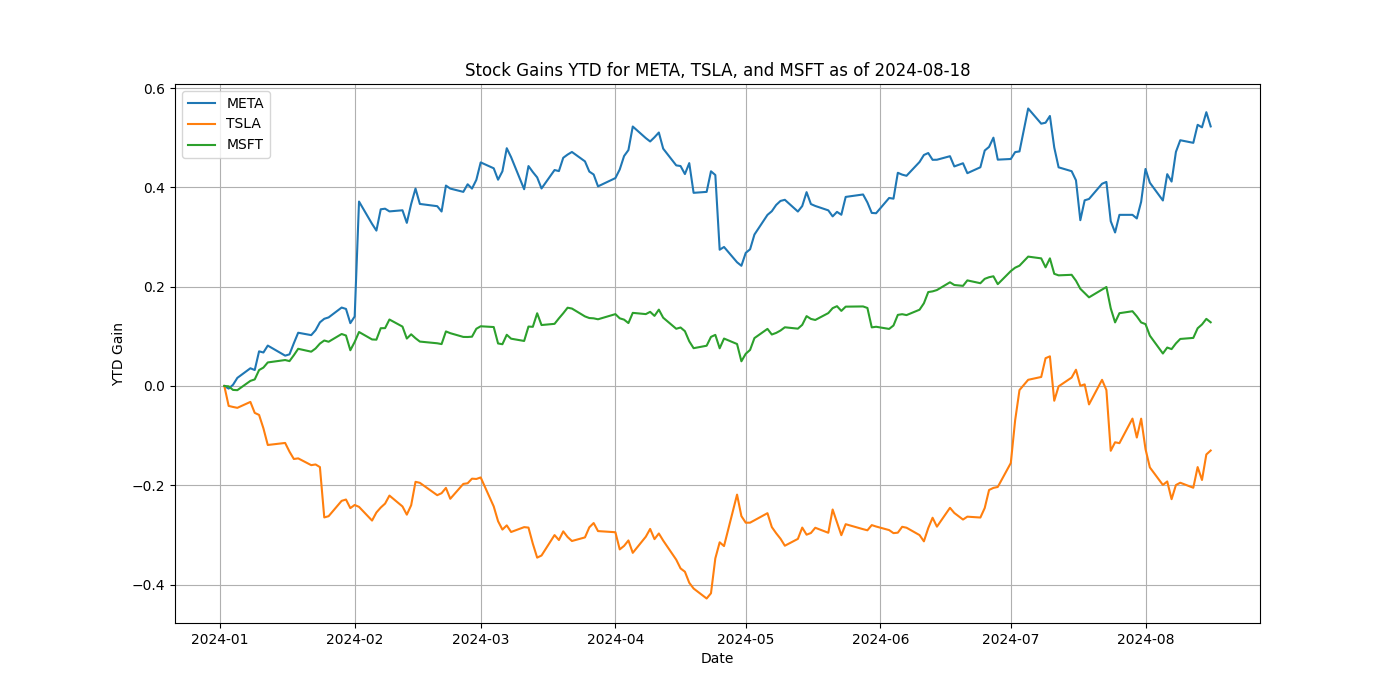

In [8]:
Image(os.path.join("my_code", "ytd_stock_gains.png"))

In [9]:
print(chat_result.summary)

The user successfully installed the `yfinance` and `matplotlib` modules, executed a Python script to fetch and plot the year-to-date (YTD) stock gains for META, TSLA, and MSFT, and saved the plot as `ytd_stock_gains.png`.


In [10]:
print(chat_result.cost)

{'usage_including_cached_inference': {'total_cost': 0.14456, 'gpt-4o-2024-05-13': {'cost': 0.14456, 'prompt_tokens': 22039, 'completion_tokens': 2291, 'total_tokens': 24330}}, 'usage_excluding_cached_inference': {'total_cost': 0}}


In [11]:
print(f"The conersation took {len(chat_result.chat_history)/2} turns in total")

The conersation took 10.0 turns in total


In [12]:
chat_result.chat_history

[{'content': 'Find out the current date and then create a plot showing stock gain YTD for META and TLSA as time series. Add the current date to the title of the plot.\nMake sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.',
  'role': 'assistant'},
 {'content': 'Sure, let\'s break down the task into steps:\n\n1. Get the current date.\n2. Fetch the year-to-date (YTD) stock data for META and TSLA.\n3. Create a time series plot showing the stock gains YTD for both stocks.\n4. Add the current date to the title of the plot.\n5. Save the figure to a file named `ytd_stock_gains.png`.\n\nHere is the complete Python code to achieve this:\n\n```python\n# filename: ytd_stock_gains.py\n\nimport datetime\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\n# Step 1: Get the current date\ncurrent_date = datetime.datetime.now().strftime("%Y-%m-%d")\n\n# Step 2: Fetch the YTD stock data for META and TSLA\nstart_date = f"{datetime.datetime.now().year}-01-0

In [13]:
import sys
sys.exit("Stopping execution at this point.")

SystemExit: Stopping execution at this point.

/home/akopp/miniconda3/envs/autogen/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Provide User-defined Functions instead of Freestyle Code generation

In [14]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

In [15]:
# clear/recreate temp coding folder
os.system("rm -rf my_code")
os.system("mkdir my_code")

# Docker must be available on the system
executor = LocalCommandLineCodeExecutor(
    timeout=120, # seconds
    work_dir="my_code",
    functions=[get_stock_prices, plot_stock_prices],
)

In [16]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

In [17]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="NEVER",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

In [18]:
import datetime
today = datetime.datetime.now().date()
message = f"""Today is {today}. Create a plot showing stock gain YTD for META and TSLA as time series.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png."""


chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
    max_turns=12,
)

code_executor_agent (to code_writer_agent):

Today is 2024-08-18. Create a plot showing stock gain YTD for META and TSLA as time series.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create a plot showing the year-to-date (YTD) stock gains for META and TSLA, we need to follow these steps:

1. Get the stock prices for META and TSLA from the start of the year (2024-01-01) to today (2024-08-18).
2. Calculate the YTD gains for each stock.
3. Plot the YTD gains as a time series.
4. Save the plot to a file named `ytd_stock_gains.png`.

Here is the complete Python code to achieve this:

```python
# filename: ytd_stock_gains.py

import pandas as pd
from functions import get_stock_prices, plot_stock_prices

# Define the stock symbols and date range
stock_symbols = ['META', 'TSLA']
start_date = '2024-01-01'
end_date = 

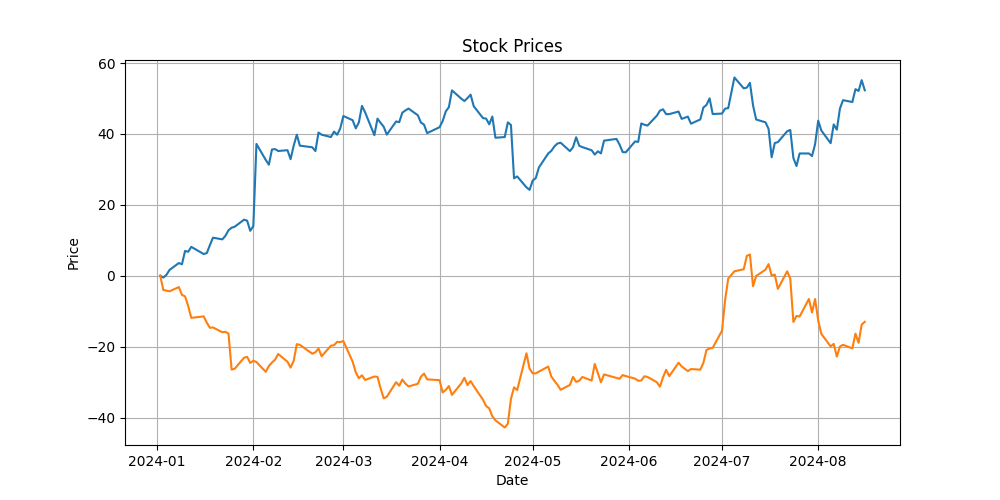

In [19]:
Image(os.path.join("my_code", "ytd_stock_gains.png"))